# Exercise Session 4
## Transfer Learning and Fine-Tuning


### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/AN2DL/Exercise_4/Notebooks

/gdrive/.shortcut-targets-by-id/16cqIj1IU0Mk9yTMy-iuEL0-7xV64i-R8/AN2DL/Exercise_4/Notebooks


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## CIFAR-100

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).

### Superclass:

- aquatic mammals

- fish

- flowers

- food containers

- fruit and vegetables

- household electrical devices

- household furniture

- insects

- large carnivores

- large man-made outdoor things

- large natural outdoor scenes 

- large omnivores and herbivores

- medium-sized mammals

- non-insect invertebrates

- people

- reptiles

- small mammals

- trees

- vehicles 1

- vehicles 2


In [5]:
# Download the data
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.cifar100.load_data('coarse')
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

169017344/169001437 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [6]:
labels = {
    0:'aquatic mammals', 
    1:'fish', 
    2:'flowers', 
    3:'food containers', 
    4:'fruit and vegetables', 
    5:'household electrical devices', 
    6:'household furniture', 
    7:'insects', 
    8:'large carnivores', 
    9:'large man-made outdoor things',
    10:'large natural outdoor scenes', 
    11:'large omnivores and herbivores', 
    12:'medium-sized mammals', 
    13:'non-insect invertebrates', 
    14:'people', 
    15:'reptiles', 
    16:'small mammals', 
    17:'trees', 
    18:'vehicles 1', 
    19:'vehicles 2'
}

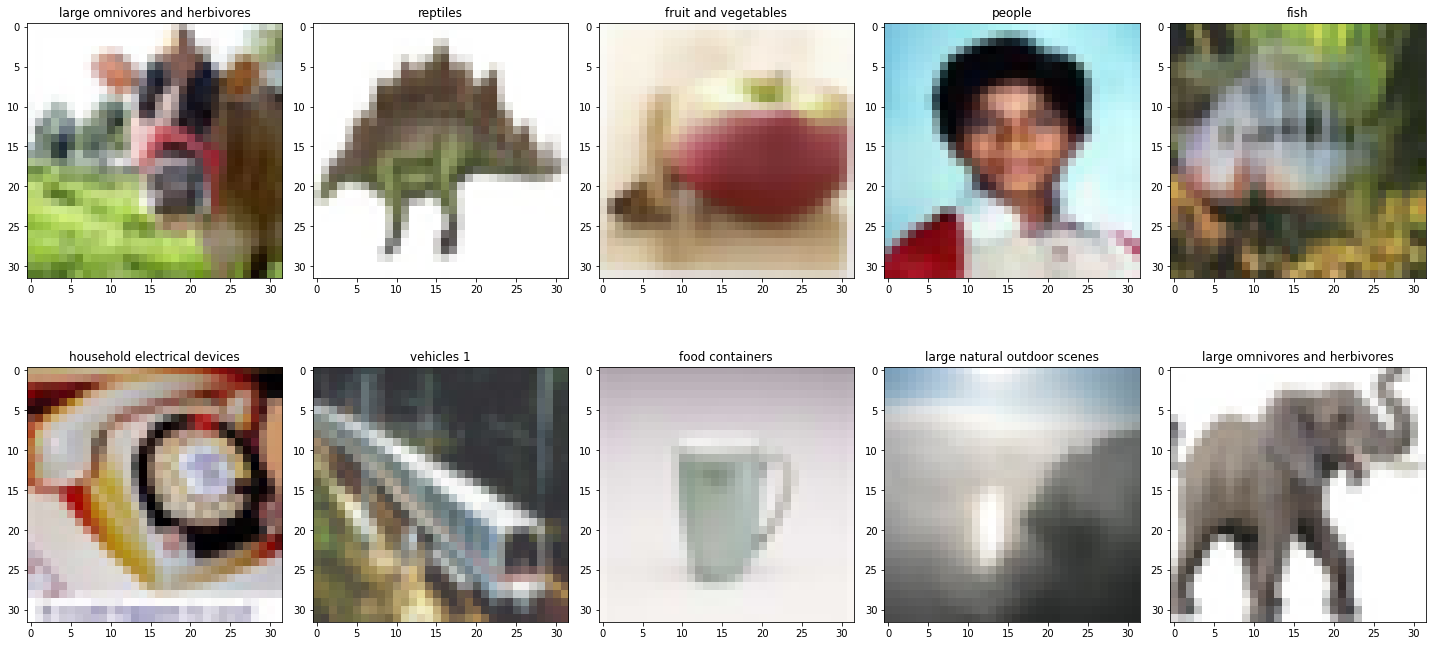

In [7]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train_val[i])
    ax.set_title('{}'.format(labels[y_train_val[i][0]]))
plt.tight_layout()
plt.show()

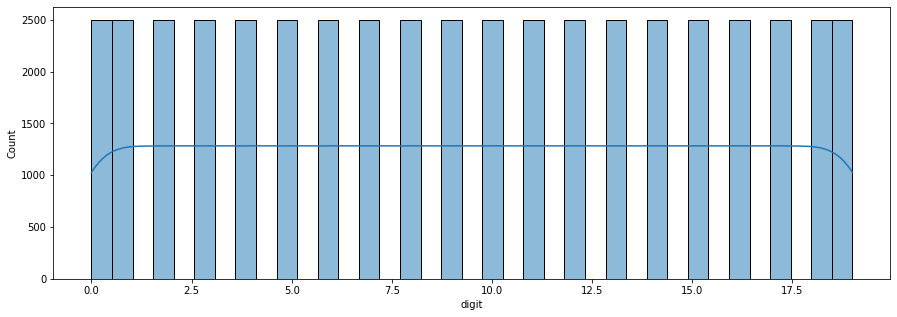

In [ ]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(y_train_val, columns=['digit']), x='digit', kde=True)
plt.show()

### Process data

In [8]:
# Normalize data
X_train_val = X_train_val/255.
X_test = X_test/255.

# Convert the label to categorical
y_train_val = tfk.utils.to_categorical(y_train_val)
y_test = tfk.utils.to_categorical(y_test)

In [9]:
# Split in train and test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=.1, stratify=y_train_val)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((45000, 32, 32, 3), (45000, 20), (5000, 32, 32, 3), (5000, 20))

In [10]:
# Compare categorical and "default" labels
print('Categorical label:',y_train[0])
print('"Default" label:',np.argmax(y_train[0]))

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
"Default" label: 6


### Models metadata

In [11]:
input_shape = X_train.shape[1:]
batch_size = 256
epochs = 200

### Standard model

In [23]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    resize_layer = tfkl.Resizing(64, 64, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv1')(resize_layer)
    pool1 = tfkl.MaxPooling2D(name = 'Pool1')(conv1)

    conv2 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv2')(pool1)
    pool2 = tfkl.MaxPooling2D(name = 'Pool2')(conv2)

    conv3 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'Conv3')(pool2)
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GloablPooling')(conv3)
    glob_pooling = tfkl.Dropout(0.3, seed=seed, name='GloablPoolingDropout')(glob_pooling)

    classifier_layer = tfkl.Dense(
        units=256,  
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Classifier')(glob_pooling)
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(classifier_layer)

    output_layer = tfkl.Dense(
        units=20, 
        activation='softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_1 (Resizing)        (None, 64, 64, 3)         0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 64)        1792      
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 32, 32, 64)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 128)       73856     
_________________________________________________________________
Pool2 (MaxPooling2D)         (None, 16, 16, 128)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 256)       295168

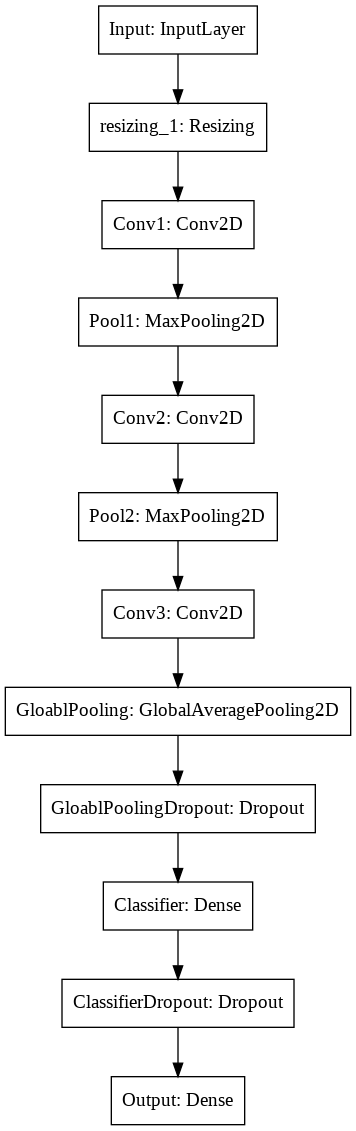

In [24]:
standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)

In [25]:
# Train the model
standard_history = standard_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
176/176 [==============================] - 27s 135ms/step - loss: 2.7811 - accuracy: 0.1286 - val_loss: 2.5822 - val_accuracy: 0.2126
Epoch 2/200
176/176 [==============================] - 23s 130ms/step - loss: 2.5354 - accuracy: 0.2090 - val_loss: 2.4100 - val_accuracy: 0.2482
Epoch 3/200
176/176 [==============================] - 23s 130ms/step - loss: 2.4264 - accuracy: 0.2406 - val_loss: 2.3928 - val_accuracy: 0.2410
Epoch 4/200
176/176 [==============================] - 23s 130ms/step - loss: 2.3498 - accuracy: 0.2635 - val_loss: 2.2965 - val_accuracy: 0.2786
Epoch 5/200
176/176 [==============================] - 23s 130ms/step - loss: 2.2785 - accuracy: 0.2862 - val_loss: 2.1860 - val_accuracy: 0.3116
Epoch 6/200
176/176 [==============================] - 23s 130ms/step - loss: 2.2121 - accuracy: 0.3086 - val_loss: 2.1130 - val_accuracy: 0.3452
Epoch 7/200
176/176 [==============================] - 23s 130ms/step - loss: 2.1444 - accuracy: 0.3282 - val_loss: 2.0715 -

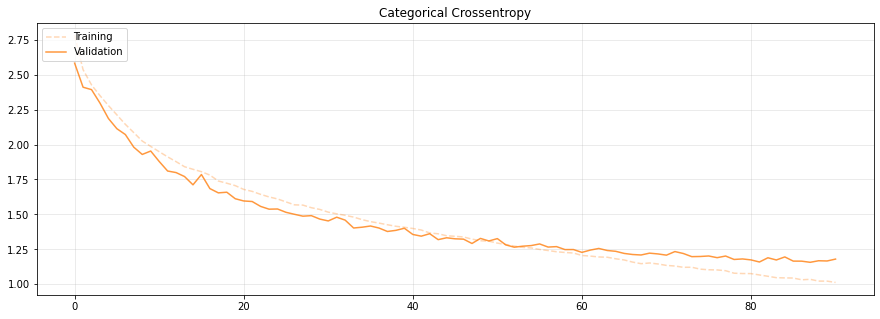

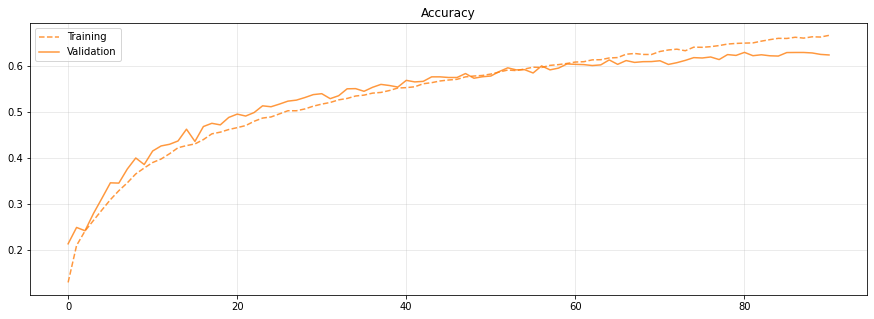

In [26]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [27]:
# Predict the test set with the CNN
predictions = standard_model.predict(X_test)
predictions.shape

(10000, 20)

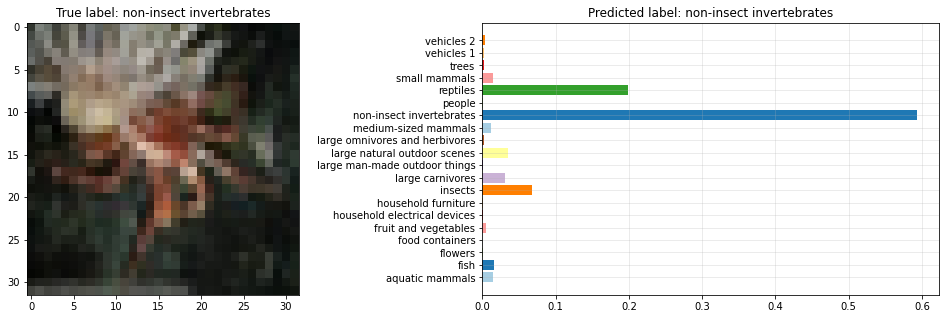

In [28]:
# Plot the target images and the predictions
prediction_index = 100

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(y_test[prediction_index])])
ax2.barh(list(labels.values()), predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('Predicted label: '+labels[np.argmax(predictions[prediction_index])])
ax2.grid(alpha=.3)
plt.show()

Accuracy: 0.627
Precision: 0.6312
Recall: 0.627
F1: 0.6249


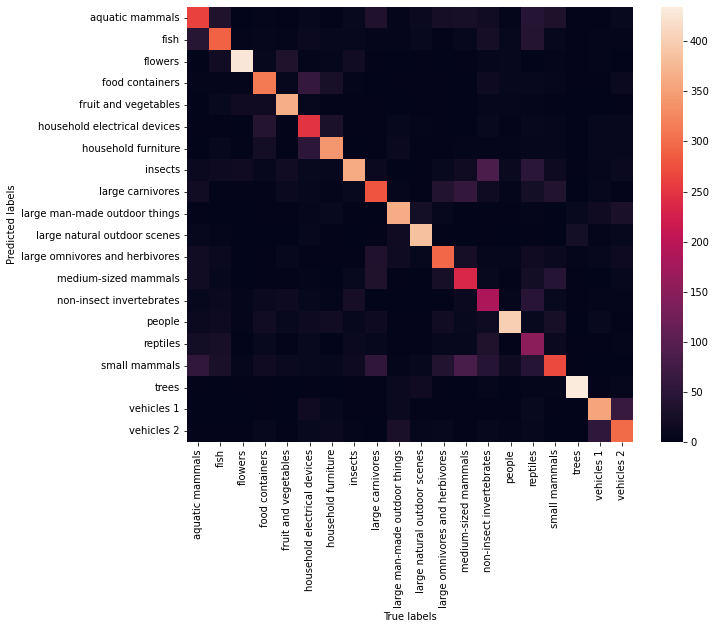

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [30]:
standard_model.save('StandardModel')
del standard_model

INFO:tensorflow:Assets written to: StandardModel/assets


INFO:tensorflow:Assets written to: StandardModel/assets


### Transfer learning

In [62]:
# Apply same preprocessing used to train the supernet 
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_ft = preprocess_input(X_train*255)
X_val_ft = preprocess_input(X_val*255)
X_test_tf = preprocess_input(X_test*255)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

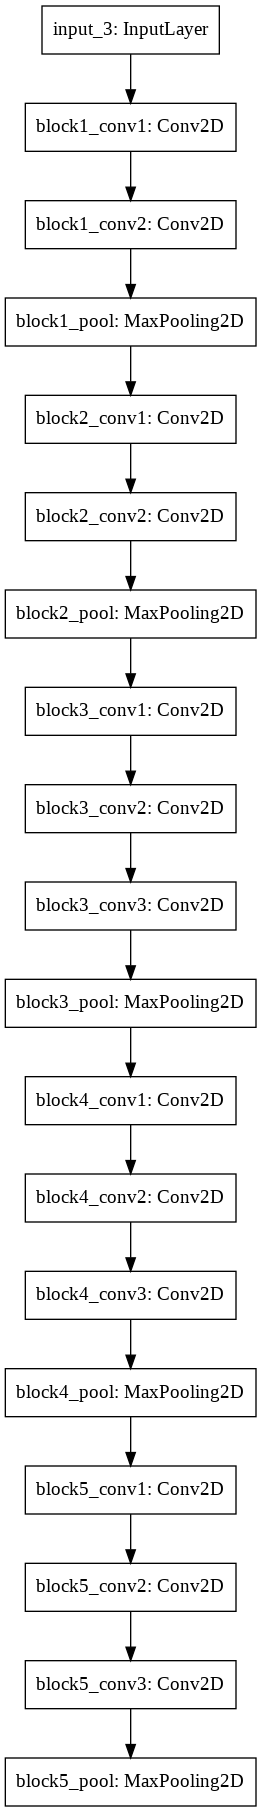

In [64]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [65]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(32,32,3))
x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    20, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing_2 (Resizing)        (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0     

In [21]:
# Train the model
tl_history = tl_model.fit(
    x = X_train_ft,
    y = y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val_ft, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
176/176 [==============================] - 52s 248ms/step - loss: 3.5832 - accuracy: 0.3784 - val_loss: 1.6560 - val_accuracy: 0.5020
Epoch 2/200
176/176 [==============================] - 34s 193ms/step - loss: 1.7003 - accuracy: 0.4933 - val_loss: 1.3964 - val_accuracy: 0.5622
Epoch 3/200
176/176 [==============================] - 34s 193ms/step - loss: 1.4960 - accuracy: 0.5401 - val_loss: 1.3067 - val_accuracy: 0.5844
Epoch 4/200
176/176 [==============================] - 34s 192ms/step - loss: 1.3656 - accuracy: 0.5702 - val_loss: 1.2340 - val_accuracy: 0.6106
Epoch 5/200
176/176 [==============================] - 34s 193ms/step - loss: 1.2772 - accuracy: 0.5933 - val_loss: 1.1865 - val_accuracy: 0.6318
Epoch 6/200
176/176 [==============================] - 34s 192ms/step - loss: 1.2040 - accuracy: 0.6174 - val_loss: 1.1473 - val_accuracy: 0.6378
Epoch 7/200
176/176 [==============================] - 34s 192ms/step - loss: 1.1457 - accuracy: 0.6292 - val_loss: 1.1210 -

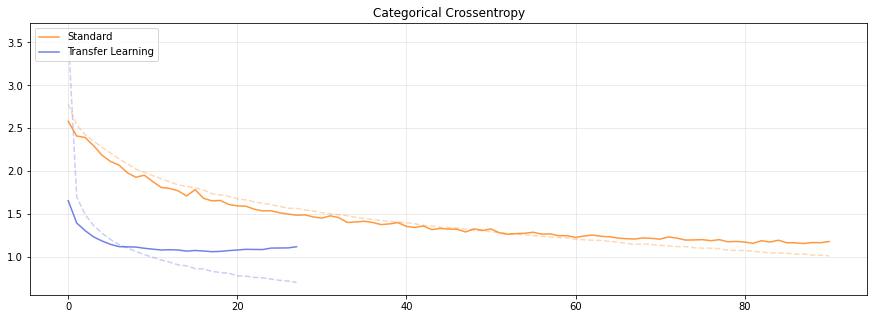

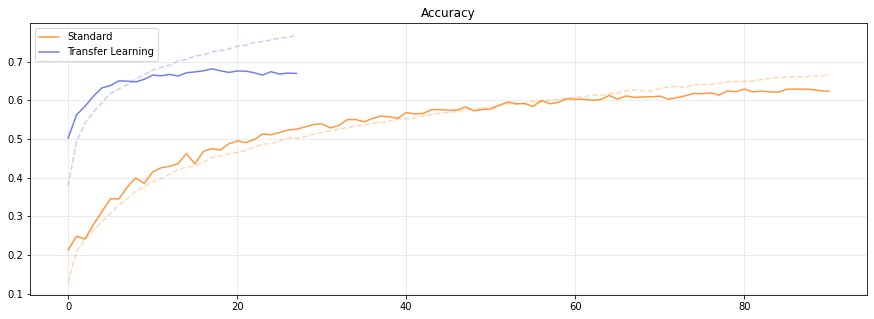

In [34]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.6683
Precision: 0.6751
Recall: 0.6683
F1: 0.6692


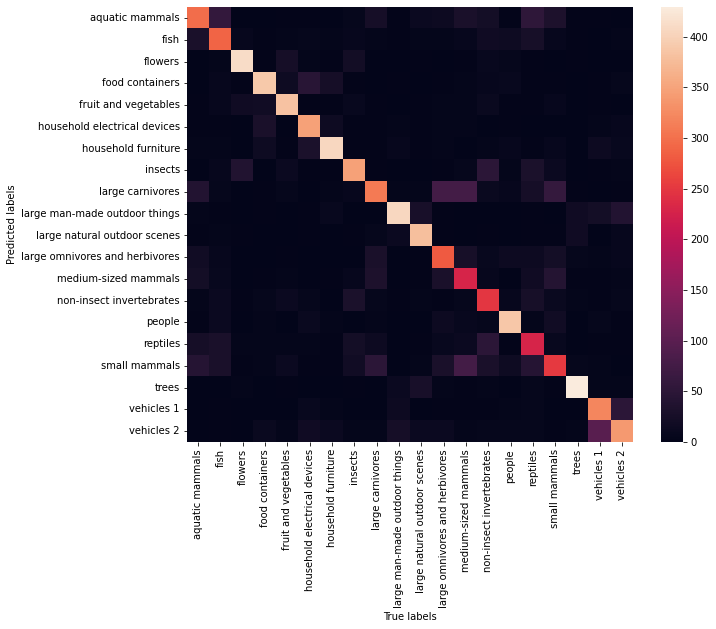

In [35]:
# Predict the test set with the CNN
predictions = tl_model.predict(X_test_tf)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [36]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model  # To avoid filling the memory

INFO:tensorflow:Assets written to: TransferLearningModel/assets


INFO:tensorflow:Assets written to: TransferLearningModel/assets


### Fine tuning

In [195]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [196]:
# Set all VGG layers to True
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [197]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:14]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 64, 64, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
Flattening (Flatten)         (None, 2048)              0        

In [198]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

In [199]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train_ft,
    y = y_train,
    batch_size = 256,
    epochs = 200,
    validation_data = (X_val_ft, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
176/176 [==============================] - 41s 229ms/step - loss: 0.9378 - accuracy: 0.6982 - val_loss: 0.9867 - val_accuracy: 0.6962
Epoch 2/200
176/176 [==============================] - 39s 224ms/step - loss: 0.7502 - accuracy: 0.7543 - val_loss: 0.9422 - val_accuracy: 0.7188
Epoch 3/200
176/176 [==============================] - 39s 224ms/step - loss: 0.6359 - accuracy: 0.7888 - val_loss: 0.9115 - val_accuracy: 0.7352
Epoch 4/200
176/176 [==============================] - 39s 223ms/step - loss: 0.5403 - accuracy: 0.8180 - val_loss: 0.8943 - val_accuracy: 0.7430
Epoch 5/200
176/176 [==============================] - 39s 224ms/step - loss: 0.4562 - accuracy: 0.8470 - val_loss: 0.9043 - val_accuracy: 0.7440
Epoch 6/200
176/176 [==============================] - 39s 223ms/step - loss: 0.3902 - accuracy: 0.8673 - val_loss: 0.8819 - val_accuracy: 0.7554
Epoch 7/200
176/176 [==============================] - 39s 224ms/step - loss: 0.3347 - accuracy: 0.8851 - val_loss: 0.9197 -

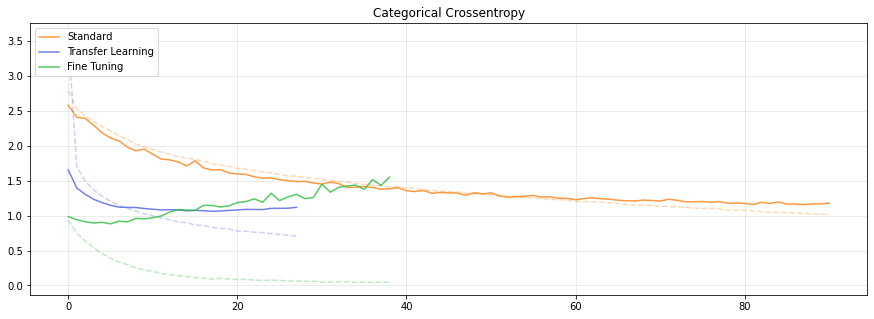

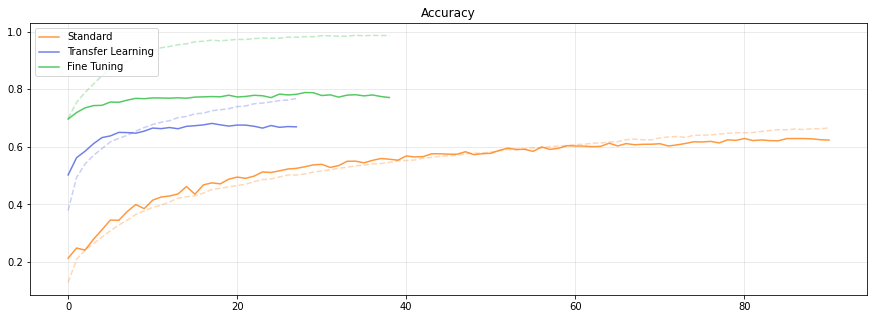

In [200]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Standard', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#2ABC3D', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#2ABC3D')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.7758
Precision: 0.7795
Recall: 0.7758
F1: 0.7767


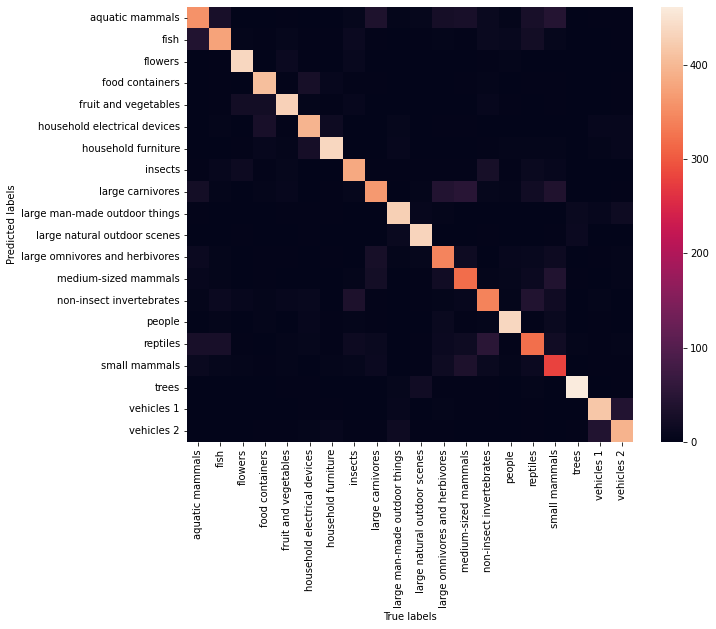

In [201]:
# Predict the test set with the CNN
predictions = ft_model.predict(X_test_tf)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [202]:
ft_model.save('FineTuningModel')
del ft_model

INFO:tensorflow:Assets written to: FineTuningModel/assets


INFO:tensorflow:Assets written to: FineTuningModel/assets
